## Intro
The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. In this project we will conduct an evaluation and make sure that the stores are equipped with the right technology and that computer vision methods are accurate. 

## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# load labels
labels = pd.read_csv('/datasets/faces/labels.csv')

# configure it to rescale the images
train_datagen = ImageDataGenerator(rescale=1./255)

# create a generator that reads images and labels from the directory
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,                
    directory='/datasets/faces/final_files/',
    x_col='file_name',               
    y_col='real_age',                
    target_size=(224, 224),          
    batch_size=32,                   
    class_mode='raw',                
    seed=12345                       
)

Found 7591 validated image filenames.


## EDA

Dataset Size: (7591, 2)


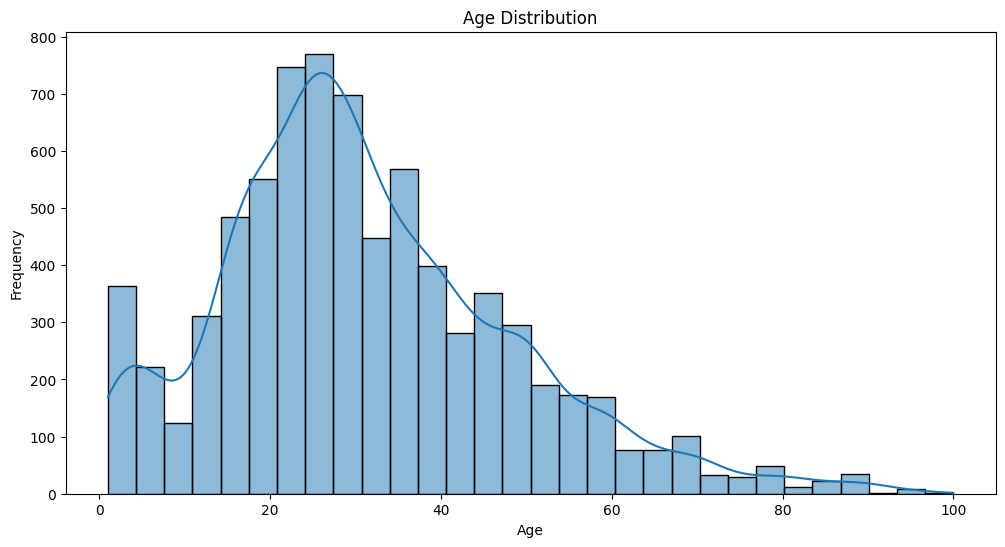

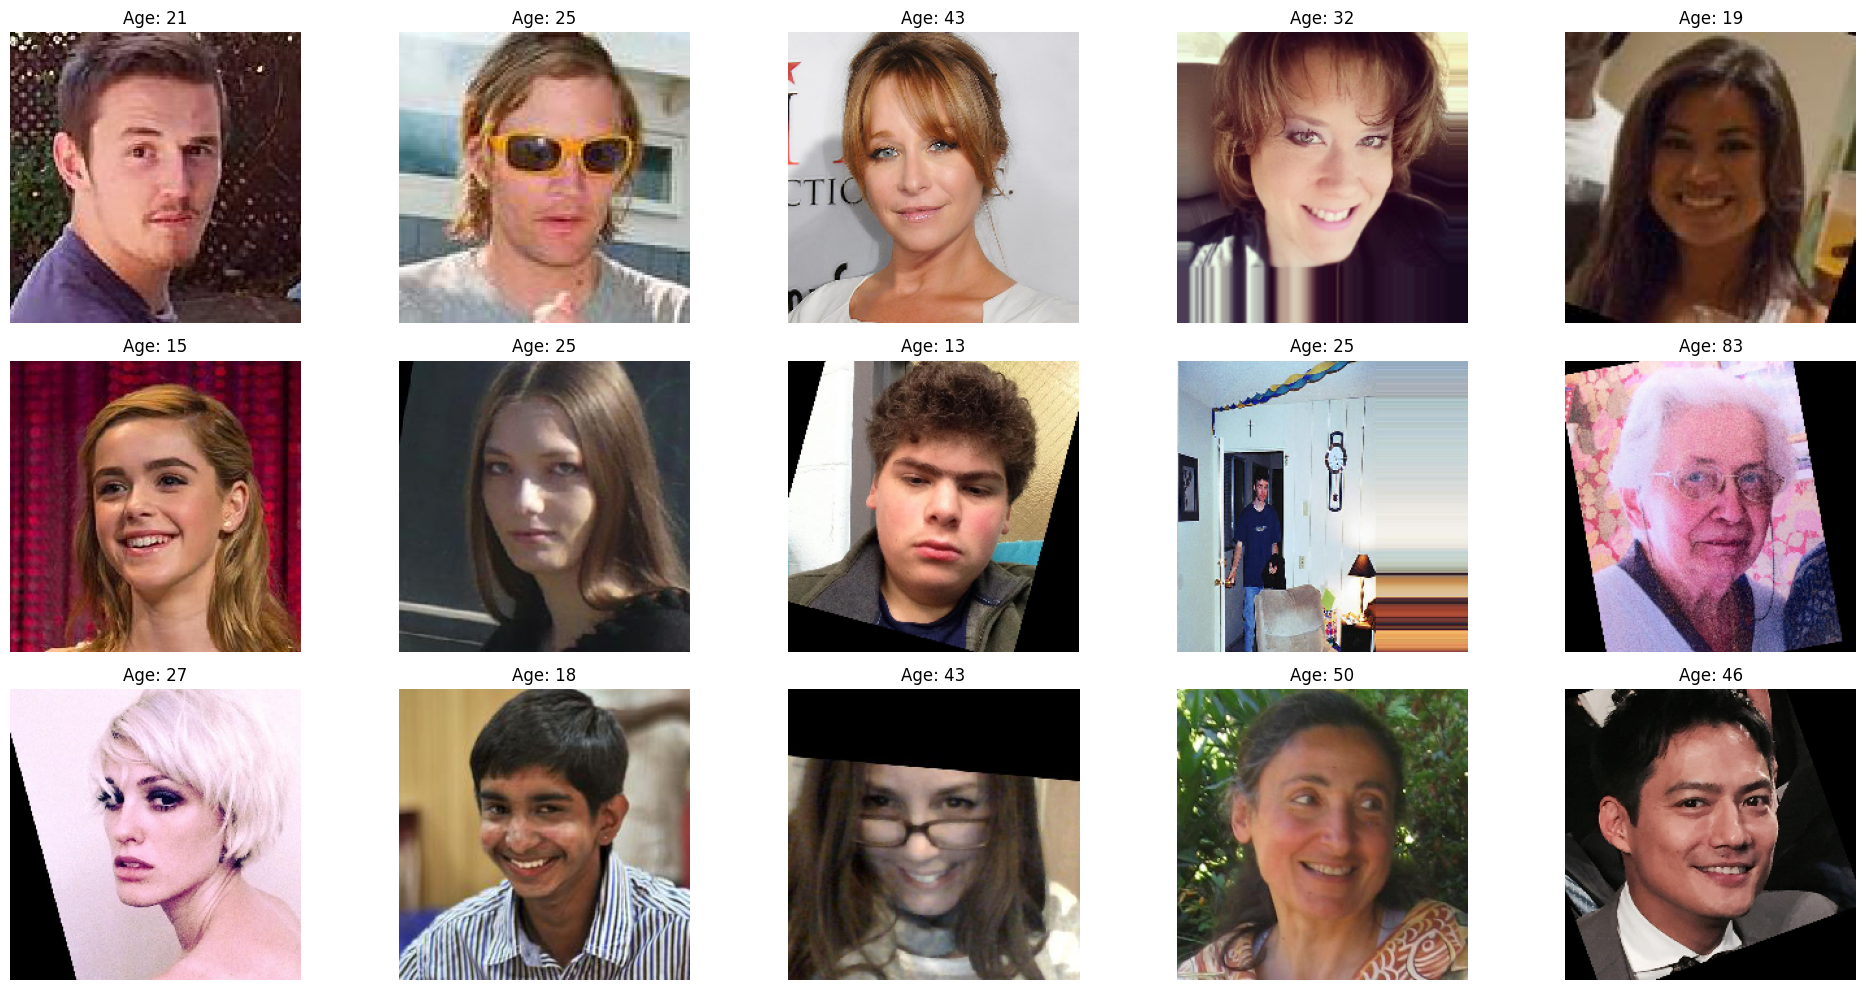

In [3]:
# look at the dataset size
print("Dataset Size:", labels.shape)

# age distribution
plt.figure(figsize=(12,6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# visualize sample images
def plot_sample_images(df, directory, num_samples=15):
    plt.figure(figsize=(20, 10))
    sample_df = df.sample(num_samples)
    for i, (index, row) in enumerate(sample_df.iterrows()):
        file_name = row['file_name']
        age = row['real_age']
        img = load_img(directory + file_name, target_size=(224, 224))
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f'Age: {age}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(labels, '/datasets/faces/final_files/')

### Findings

The plot distribution shows that there are ages from 0 to 100. The frequency in ages is most between 20 and 40. It looks to me that the ages in this dataset range from 4 to at least 45 from the image samples.  There is a high number of faces that are in their twenties. This could mean that there is a potential imabalance. The sample images do show a broad ranger in gender, ethnicity and age.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [4]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # load the labels 
    labels = pd.read_csv(path + '/labels.csv')
    
    # configure it to rescale the images
    train_datagen = ImageDataGenerator(rescale=1./255)
    
    # create a generator that reads images and labels from the directory for the train set
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,                
        directory=f"{path}/final_files/", 
        x_col='file_name',               
        y_col='real_age',                
        target_size=(224, 224),          
        batch_size=32,                   
        class_mode='raw',                
        seed=12345                       
    )

    return train_gen_flow

In [6]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # load the labels
    labels = pd.read_csv(path + '/labels.csv')
    
    # configure it to rescale the images
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # create a generator that reads images and labels from the directory for the test set
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,                
        directory=f"{path}/final_files/", 
        x_col='file_name',               
        y_col='real_age',                
        target_size=(224, 224),          
        batch_size=32,                   
        class_mode='raw',                
        seed=12345                       
    )

    return test_gen_flow

In [7]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # load the ResNet50 model pretrained on ImageNet
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    # define 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    # compile 
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


    return model

In [8]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # check
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    # model training    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)


    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [9]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [10]:
main_str = """
if __name__ == "__main__":
    train_data_path = "/path/to/train/data"  
    test_data_path = "/path/to/test/data"    

    train_data = load_train(train_data_path)
    test_data = load_test(test_data_path)

    input_shape = (224, 224, 3)
    model = create_model(input_shape)

    model = train_model(model, train_data, test_data, epochs=20)

    model.save("age_prediction_model.h5")
"""
with open('run_model_on_gpu.py', 'a') as f:
    f.write(main_str)

### Output

Epoch 1/20 356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921 Epoch 2/20 356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035 Epoch 3/20 356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454 Epoch 4/20 356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481 Epoch 5/20 356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192 Epoch 6/20 356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332 Epoch 7/20 356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359 Epoch 8/20 356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239 Epoch 9/20 356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529 Epoch 10/20 356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629 Epoch 11/20 356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866 Epoch 12/20 356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591 Epoch 13/20 356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467 Epoch 14/20 356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401 Epoch 15/20 356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841 Epoch 16/20 356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304 Epoch 17/20 356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419 Epoch 18/20 356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226 Epoch 19/20 356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908 Epoch 20/20 356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

### Training Output

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035


...


Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512


## Conclusions

The project successfully developed a convolutional neural network (CNN) model to estimate a person's age from their photo using computer vision. The dataset, which contained a higher concentration of younger individuals, required careful handling to avoid bias. The ResNet50 model, pre-trained on ImageNet, was adapted for regression by adding a Global Average Pooling layer and a fully connected output layer. Training on a GPU platform yielded a training MAE of 3.1785 and a validation MAE of 7.6512, with performance improving over epochs.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training